<h1 style=\"text-align: center; font-size: 50px;\"> ⚙️ Run Workflow </h1>

📘 Project Overview: 
 This notebook demonstrates a modular architecture for answering natural language questions 
 over a GitHub Repo using only local and open-source models (e.g., LLaMA.cpp).
 The system processes long documents chunk-by-chunk and synthesizes a final answer using a multi-step LLM workflow.

# Notebook Overview

- Start Execution
- Define User Constants
- Install and Import Libraries
- Configure Settings
- Verify Assets
- KV Memory
- Download the GitHub Repo
- LLM Setup
- State Model
- Node Functions
- Graph Definition
- Graph Visualization
- Generated Answer
- Message History

# Start Execution

In [1]:
# Standard library imports
import os  # Provides OS-related utilities
import sys  # Allows manipulation of Python runtime environment
import time  # Enables time-based operations
from pathlib import Path  # Object-oriented file system paths

# Extend sys.path to allow importing from parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Local application-specific imports
from src.simple_kv_memory import SimpleKVMemory  # In-memory key-value store for agent state
from src.utils import (  # Utility functions for logging, LLM I/O, and schema generation
    display_image,
    get_response_from_llm,
    json_schema_from_type,
    log_timing,
    logger,
)

In [2]:
start_time = time.time()  
logger.info("Notebook execution started.")

# Define User Constants

In [3]:
TOPIC: str = "Classification Algorithms"  
QUESTION: str = "Which machine learning classification algorithms are used in this project?"
REPO_URL: str = "https://github.com/HPInc/AI-Blueprints" 
FOLDER_PATH: Path = Path("data-science/classification-with-svm") 

# Install and Import Libraries

In [4]:
%%time

%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.
CPU times: user 23 ms, sys: 8.87 ms, total: 31.9 ms
Wall time: 1.3 s


In [5]:
from __future__ import annotations  # Enables postponed evaluation of annotations (PEP 563)

# ─────── Standard Library Imports ───────
import base64                        # Encoding and decoding binary data
import functools                     # Higher-order functions and decorators
import io                            # Core tools for stream handling
import json                          # JSON serialization and deserialization
import logging                       # Logging configuration
import multiprocessing               # Multi-process parallelism
import os                            # OS-level operations
import shutil                        # File and directory operations
import sys                           # System-specific parameters and functions
import time                          # Time tracking utilities
import warnings                      # Warning control
import zipfile                       # Archive file handling
from collections import namedtuple   # Lightweight immutable object containers
from pathlib import Path             # Filesystem path manipulation
from typing import (
    Any, Dict, List, Literal, Optional, TypedDict  # Static type hints
)

# ─────── Third-Party Packages ───────
import requests                      # HTTP requests for external resources
import yaml  # YAML parsing and serialization
from IPython.display import Markdown, display  # IPython utilities for notebook output formatting
from tqdm import tqdm  # Visual progress bar for loops

# ─────── LangChain Core & Community ───────
from langchain.docstore.document import Document  # Core document abstraction
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Text chunking utility
from langchain_community.document_loaders import (  # Loaders for various document types
    CSVLoader,
    PyPDFLoader,
    TextLoader,
    UnstructuredExcelLoader,
    UnstructuredMarkdownLoader,
    UnstructuredWordDocumentLoader,
)
from langchain_community.llms import LlamaCpp  # Integration for local LlamaCpp models

# ─────── LangGraph ───────
from langgraph.graph import END, START, StateGraph  # Graph components for stateful workflows

# Configure Settings

In [6]:
# Suppress Python warnings
warnings.filterwarnings("ignore")

In [7]:
REPO_NAME = Path(REPO_URL.split('/')[-1] + '-main')

In [8]:
INPUT_PATH: Path = Path("../data/input/downloaded_repo") / REPO_NAME /  FOLDER_PATH
MEMORY_PATH: Path = Path("../data/memory")   
MODEL_PATH = "/home/jovyan/datafabric/meta-llama3.1-8b-Q8/Meta-Llama-3.1-8B-Instruct-Q8_0.gguf"
CONTEXT_WINDOW = 8192
MAX_TOKENS = CONTEXT_WINDOW // 8
CHUNK_SIZE = CONTEXT_WINDOW // 2
CHUNK_OVERLAP = CHUNK_SIZE // 16

In [9]:
logger.info('Notebook execution started.')

## Verify Assets

In [10]:
def log_asset_status(asset_path: str, asset_name: str) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured.")
    else:
        logger.info(f"{asset_name} is not properly configured. Please ensure the required asset is correctly configured in your AI Studio project according to the README file.")

In [11]:
log_asset_status(
    asset_path=INPUT_PATH,
    asset_name="Input Data",
)
log_asset_status(
    asset_path=MODEL_PATH,
    asset_name="LLM",
)

# LLM Setup

In [12]:
%%time

llm = LlamaCpp(
    model_path=MODEL_PATH,
    n_gpu_layers=-1,                             
    n_batch=512,                                 
    n_ctx=CONTEXT_WINDOW,
    max_tokens=MAX_TOKENS,
    f16_kv=True,
    use_mmap=False,                             
    low_vram=False,                            
    rope_scaling=None,
    temperature=0.0,
    repeat_penalty=1.0,
    streaming=False,
    stop=None,
    seed=42,
    num_threads=multiprocessing.cpu_count(),
    verbose=False                                
)

CPU times: user 1.43 s, sys: 2.73 s, total: 4.16 s
Wall time: 1min 2s


# KV Memory

In [13]:
memory: SimpleKVMemory = SimpleKVMemory(MEMORY_PATH)

# Download the GitHub Repo

In [14]:
def download_github_repo(repo_url: str, output_dir: str = "../data/input/downloaded_repo") -> Path:
    """
    Download and extract a public GitHub repository as a zip file.

    Args:
        repo_url (str): The GitHub URL (e.g., https://github.com/HPInc/AI-Blueprints)
        output_dir (str): Directory to extract the repo contents into.

    Returns:
        Path: Path to the extracted root folder.
    """
    # Normalize URL
    repo_url = repo_url.rstrip("/")
    if not repo_url.startswith("https://github.com/"):
        raise ValueError("URL must be a valid GitHub repository URL.")

    # Extract user/repo name
    parts = repo_url.replace("https://github.com/", "").split("/")
    if len(parts) != 2:
        raise ValueError("URL must be in format: https://github.com/owner/repo")

    owner, repo = parts
    zip_url = f"https://github.com/{owner}/{repo}/archive/refs/heads/main.zip"

    print(f"📦 Downloading repo zip from: {zip_url}")
    response = requests.get(zip_url)
    response.raise_for_status()

    # Extract zip contents
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(output_dir)

    # The zip structure is usually: output_dir/repo-main/
    extracted_path = Path(output_dir) / f"{repo}-main"
    print(f"✅ Repository extracted to: {extracted_path.resolve()}")

    return extracted_path

In [15]:
%%time

download_github_repo(REPO_URL)

📦 Downloading repo zip from: https://github.com/HPInc/AI-Blueprints/archive/refs/heads/main.zip
✅ Repository extracted to: /home/jovyan/agentic-github-repo-analyzer-with-langgraph/data/input/downloaded_repo/AI-Blueprints-main
CPU times: user 923 ms, sys: 785 ms, total: 1.71 s
Wall time: 31.9 s


PosixPath('../data/input/downloaded_repo/AI-Blueprints-main')

# State Model

In [16]:
class AgenticState(TypedDict, total=False):
    """
    Represents the internal state of an agentic feedback analysis pipeline.
    This state is passed through the LangGraph nodes.
    """

    # Input metadata
    topic: str
    input_path: str
    question: str

    # Document & chunking
    docs: str                      # Raw or combined document content
    chunks: str                    # Raw or processed chunks

    # LLM configuration
    llm: LlamaCpp
    rewritten_question: Optional[str]

    # Processing logic
    is_relevant: Optional[bool]
    from_memory: Optional[bool]
    chunk_responses: str

    # Output
    answer: Optional[str]

    # Memory and conversation
    memory: SimpleKVMemory
    messages: List[Dict[str, Any]]  # Full conversation history with the LLM

# Node Functions

In [17]:
@log_timing
def ingest_question(state: AgenticState) -> Dict[str, Any]:
    """
    Record the user's input question and append it to the system message history.

    Returns:
        Dict[str, Any]: A dictionary with the updated message history.
    """
    question = state["question"].strip()
    logger.info("🗣️ Ingested user question: %s", question)

    # Build updated message history
    messages = state.get("messages", [])
    messages += [
        {"role": "developer", "content": "User submitted a question."},
        {"role": "user", "content": question},
    ]

    return {"messages": messages}


@log_timing
def check_relevance(state: AgenticState) -> Dict[str, Any]:
    """
    Determines whether the user's question is relevant to the given topic using the LLM.

    If irrelevant, returns a polite default answer and flags the result.
    """
    topic = state["topic"]
    question = state["question"]
    llm = state["llm"]

    # Define strict classification prompts
    system_prompt = (
        "You are a binary classification assistant designed to evaluate the relevance of user questions "
        "to a specified topic in a document intelligence system.\n\n"
        "Your task is to determine whether a user's question is relevant to the topic — either directly or indirectly — "
        "based on whether the question could help support, relate to, or expand a conversation or analysis about that topic.\n\n"
        "Rules:\n"
        "- Only respond with 'yes' or 'no' — no punctuation, no elaboration, and no additional words.\n"
        "- If the question is clearly about the topic, answer 'yes'.\n"
        "- If the question does not mention the topic directly but can logically contribute to answering, clarifying, or deepening understanding about the topic, answer 'yes'.\n"
        "- Only answer 'no' if the question is completely unrelated or disconnected from the topic and cannot be used in any meaningful way to explore it.\n\n"
        "Your judgment should be inclusive — if there's any reasonable connection or utility, classify it as relevant ('yes')."
    )


    user_prompt = (
        f"Topic: \"{topic}\"\n"
        f"User's Question: \"{question}\"\n\n"
        "Determine if the question is relevant to the topic.\n"
        "A question is considered relevant if it:\n"
        "- Directly asks about the topic, or\n"
        "- Could be used to inform, support, or guide a discussion, analysis, or answer related to the topic.\n\n"
        "If there's any logical connection between the question and the topic — even if implicit — respond with 'yes'.\n"
        "Respond strictly with one word: 'yes' or 'no'.\n"
        "Answer:"
    )


    # Get LLM response
    response = get_response_from_llm(llm, system_prompt, user_prompt).strip().lower()
    is_relevant = response == "yes"

    logger.info("🧠 Relevance response: %s → %s", response, "Relevant" if is_relevant else "Irrelevant")

    # Append LLM trace and result
    messages = state.get("messages", [])
    messages += [
        {"role": "developer", "content": "🧠 Relevance check result:"},
        {"role": "assistant", "content": response},
    ]

    result: Dict[str, Any] = {
        "is_relevant": is_relevant,
        "messages": messages,
    }

    if not is_relevant:
        result["answer"] = f"🚫 Sorry, I can only answer questions related to '{topic}'."

    return result


@log_timing
def check_memory(state: AgenticState) -> Dict[str, Any]:
    """
    Check if the user's question has been previously answered and cached in memory.

    If found, return the cached answer along with a `from_memory` flag.
    """
    question = state["question"]
    memory = state["memory"]

    key = question.strip().lower()
    cached_answer = memory.get(key)

    messages = state.get("messages", [])

    if cached_answer:
        logger.info("💾 Cache hit for question: %s", question)
        messages.append({
            "role": "developer",
            "content": f"💾 Retrieved cached answer for question: '{question}'"
        })
        return {
            "answer": cached_answer,
            "from_memory": True,
            "messages": messages
        }

    logger.info("🧭 Cache miss for question: %s", question)
    messages.append({
        "role": "developer",
        "content": f"🧭 No cached answer found for question: '{question}'"
    })
    return {
        "from_memory": False,
        "messages": messages
    }


@log_timing
def rewrite_question(state: AgenticState) -> Dict[str, Any]:
    """
    Refines the user's original question into a clear, specific, and LLM-optimized form.

    Returns:
        Dict[str, Any]: Contains the rewritten question and updated message history.
    """
    original_question = state["question"].strip()
    llm = state["llm"]

    # Prompt engineering
    system_prompt = (
        "You are a professional assistant that rewrites vague or ambiguous questions "
        "into clear, focused, and LLM-friendly formats.\n"
        "The rewritten question must:\n"
        "- Be specific to document analysis\n"
        "- Be grammatically correct\n"
        "- Remain a QUESTION (not a statement)\n"
        "- Avoid ambiguity or conversational phrasing\n"
        "Do NOT include explanations or formatting—just return the cleaned question."
    )

    user_prompt = (
        f"Original user question:\n\"{original_question}\"\n\n"
        "Rewrite the question above as a clear and concise instruction for an AI to answer using document content. "
        "Ensure it remains in question form, not declarative."
    )

    # Run LLM
    response = get_response_from_llm(llm, system_prompt, user_prompt)
    rewritten = response.strip()

    # Log and message updates
    logger.info("✏️ Rewritten user question:\n→ %s", rewritten)

    messages = state.get("messages", [])
    messages += [
        {"role": "developer", "content": "✏️ Rewritten user question:"},
        {"role": "assistant", "content": rewritten},
    ]

    return {
        "rewritten_question": rewritten,
        "messages": messages,
    }


@log_timing
def load_input_files(state: AgenticState) -> Dict[str, Any]:
    """
    Load all supported document files from the specified input directory.

    Supported formats:
        - .txt (plain text)
        - .csv (UTF-8 with comma delimiter)
        - .xlsx (Excel)
        - .docx (Word)
        - .pdf  (PDF)
        - .md   (Markdown)
        - .py   (Python source)
        - .ipynb (Jupyter Notebooks)
        - .json (JSON config/data)
        - .yaml / .yml (YAML files)

    Skips hidden or system folders (e.g., .git, __pycache__).
    """

    class SafeTextLoader(TextLoader):
        def load(self) -> list[Document]:
            encodings = ["utf-8", "utf-16", "latin-1", "cp1252"]
            for enc in encodings:
                try:
                    with open(self.file_path, encoding=enc) as f:
                        text = f.read()
                    return [Document(page_content=text)]
                except Exception:
                    continue
            raise ValueError(f"Failed to decode file: {self.file_path}")

    class NotebookLoader:
        def __init__(self, file_path: str):
            self.file_path = file_path

        def load(self) -> list[Document]:
            try:
                with open(self.file_path, encoding="utf-8") as f:
                    notebook = json.load(f)
                cells = notebook.get("cells", [])
                source = "\n".join("".join(cell.get("source", [])) for cell in cells)
                return [Document(page_content=source)]
            except Exception as e:
                raise ValueError(f"Failed to load notebook: {self.file_path}: {e}")

    input_path = state["input_path"]
    logger.info("📂 Scanning directory for documents: %s", input_path)

    supported_extensions = {
        ".txt": SafeTextLoader,
        ".csv": lambda path: CSVLoader(path, encoding="utf-8", csv_args={"delimiter": ","}),
        ".xlsx": UnstructuredExcelLoader,
        ".docx": UnstructuredWordDocumentLoader,
        ".pdf": PyPDFLoader,
        ".md": UnstructuredMarkdownLoader,
        ".py": SafeTextLoader,
        ".json": SafeTextLoader,
        ".yml": SafeTextLoader,
        ".yaml": SafeTextLoader,
        ".ipynb": NotebookLoader,
    }

    all_docs = []

    for file_path in Path(input_path).rglob("*"):
        if any(part.startswith(".") and part not in {".", ".."} for part in file_path.parts):
            continue

        if file_path.is_dir():
            continue

        ext = file_path.suffix.lower()
        loader_class = supported_extensions.get(ext)

        if loader_class:
            try:
                loader = loader_class(str(file_path))
                docs = loader.load()
                all_docs.extend(docs)
                logger.info("✅ Loaded %d docs from %s", len(docs), file_path.name)
            except Exception as e:
                logger.warning("❌ Failed to load %s: %s", file_path.name, e)
        else:
            logger.info("⚠️ Unsupported file type: %s", file_path.name)

    messages = state.get("messages", []) + [
        {"role": "developer", "content": f"📄 Loaded documents from: {input_path}"}
    ]

    return {"docs": all_docs, "messages": messages}


@log_timing
def create_chunks(state: AgenticState) -> Dict[str, Any]:
    """
    Split all loaded documents into semantically coherent, overlapping chunks.

    Uses LangChain's RecursiveCharacterTextSplitter to preserve context boundaries
    and control token limits for downstream LLM usage.

    Returns:
        Dict[str, Any]: Contains a "chunks" key with the resulting split Document list.
    """
    docs = state["docs"]
    logger.info("📑 Starting chunking for %d loaded documents", len(docs))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        separators=["\n\n", "\n", ".", "!", "?", " ", ""],  # Order: most to least semantic
        add_start_index=True,
    )

    chunks = splitter.split_documents(docs)
    logger.info("🧩 Created %d total chunks (size=%d, overlap=%d)", len(chunks), CHUNK_SIZE, CHUNK_OVERLAP)

    # Append developer message
    messages = state.get("messages", [])
    messages.append({
        "role": "developer",
        "content": f"🧩 Chunked {len(docs)} documents into {len(chunks)} chunks (size={CHUNK_SIZE}, overlap={CHUNK_OVERLAP})"
    })

    return {
        "chunks": chunks,
        "messages": messages,
    }


@log_timing
def generate_answer_per_chunks(state: AgenticState) -> Dict[str, Any]:
    """
    Generate an answer for each document chunk based on the rewritten question.

    Each chunk is independently evaluated by the LLM using a shared system/user prompt pair.
    Only the information inside the chunk may be used—no inference or guessing allowed.
    """
    rewritten_question = state["rewritten_question"].strip()
    chunks = state["chunks"]
    llm = state["llm"]
    topic = state["topic"]
    
    logger.info("🧩 Generating answers for %d chunks using rewritten question: '%s'", len(chunks), rewritten_question)

    # 🔒 System Prompt (invariant per chunk)
    system_prompt = (
        "You are a document chunk analysis assistant for a feedback intelligence system.\n\n"
        "Your task is to help answer a specific user question by analyzing **one chunk** of a larger document.\n\n"
        "Instructions:\n"
        "- You are only given one chunk at a time.\n"
        "- Use only the information in that chunk to answer.\n"
        "- Do NOT guess, infer, or draw conclusions from missing context.\n"
        "- If the chunk does not provide enough information to answer, reply exactly with: Not mentioned in this chunk.\n\n"
        "Output Guidelines:\n"
        "- Be factual, clear, and complete.\n"
        "- Use relevant details from the chunk if available.\n"
        "- If the question is not answerable from the chunk, respond accordingly and concisely.\n"
    )

    # 🧾 User Prompt Template
    user_prompt_template = (
        f"User question:\n"
        f"\"{rewritten_question}\"\n\n"
        f"This chunk is part of a document about the topic: \"{topic}\".\n"
        f"Read the chunk carefully and answer the question using only what is written below:\n\n"
        f"--- START OF CHUNK ---\n"
        f"{{chunk}}\n"
        f"--- END OF CHUNK ---\n\n"
        f"If the answer is not found in this chunk, respond with:\n"
        f"Not mentioned in this chunk."
    )

    chunk_responses = []
    messages = state.get("messages", [])

    progress_bar = tqdm(chunks, desc="🔁 Processing each chunk")

    for i, chunk in enumerate(progress_bar):
        chunk_text = chunk.page_content.strip()
        user_prompt = user_prompt_template.replace("{chunk}", chunk_text)

        try:
            response = get_response_from_llm(llm, system_prompt, user_prompt).strip()
            progress_bar.set_postfix({"group": f"✅ Chunk {i + 1} response length: {len(response)} chars"})
        except Exception as e:
            response = f"[ERROR in chunk {i+1}]: {e}"
            progress_bar.set_postfix({"group": f"❌ Error processing chunk {i + 1}: {e}"})

        chunk_responses.append(response)

    logger.info("🧠 Finished generating %d chunk-level responses.", len(chunk_responses))

    # Add summary message
    messages.append({
        "role": "developer",
        "content": f"🧠 Processed {len(chunks)} chunks for question: '{rewritten_question}'"
    })

    return {
        "chunk_responses": chunk_responses,
        "messages": messages,
    }

@log_timing
def generate_synthetized_answer(state: AgenticState) -> Dict[str, Any]:
    """
    Synthesizes a final, comprehensive answer to the user's question
    based on the collected per-chunk LLM responses.
    """
    chunk_answers = state["chunk_responses"]
    rewritten_question = state["rewritten_question"]
    topic = state["topic"]
    llm = state["llm"]

    if not chunk_answers:
        logger.warning("🚫 No chunk-level responses available to synthesize.")
        return {"answer": "No information available to synthesize a final answer."}

    max_context_tokens = getattr(llm, "context_window", 8192)
    chunk_token_budget = max_context_tokens // 2

    # 🧱 Split formatted chunk answers into token-safe groups
    def chunk_by_token_limit(answers: List[str], max_tokens: int) -> List[List[str]]:
        groups, current, current_len = [], [], 0
        for a in answers:
            a = a.strip()
            tokens = int(a.count(" ") * 1.5)
            if current_len + tokens > max_tokens and current:
                groups.append(current)
                current, current_len = [], 0
            current.append(a)
            current_len += tokens
        if current:
            groups.append(current)
        return groups

    grouped_chunks = chunk_by_token_limit(chunk_answers, chunk_token_budget)

    logger.info("🧠 Synthesizing across %d chunk groups", len(grouped_chunks))

    logger.info("🧠 Synthesizing final answer from %d chunk responses", len(chunk_answers))

    # 🧠 System Prompt (for synthesis agent)
    synthesis_system_prompt = (
        "You are a synthesis assistant in a document reasoning system.\n\n"
        "Your job is to produce a final, complete, and precise answer to the user's question "
        "based on multiple intermediate answers derived from different chunks of a document.\n\n"
        "Instructions:\n"
        "- Use ONLY the information provided in the chunk responses.\n"
        "- Do NOT hallucinate, invent, or infer beyond what's included.\n"
        "- Eliminate redundancy and merge overlapping information.\n"
        "- Combine details and structure them clearly.\n"
        "- Be detailed, factual, and coherent.\n"
        "- Avoid repeating redundant or identical statements from the chunks; instead, consolidate and rephrase them concisely.\n"
        "- Format the answer using valid and clean Markdown for headings, lists, and emphasis.\n"
        "- **Return the final answer in clean and well-formatted Markdown.**\n"
    )

    progress_bar = tqdm(grouped_chunks, desc="🔁 Processing each grouped chunk answers")

    partial_summaries = [] 

    for i, chunk_group in enumerate(progress_bar):
        formatted_chunks = "\n".join(f"- Chunk {j+1}: {a}" for j, a in enumerate(chunk_group))
        # 💬 User Prompt Template
        synthesis_user_prompt = (
            f"The user asked the following question:\n"
            f"\"{rewritten_question}\"\n\n"
            f"The topic of the document is: \"{topic}\"\n\n"
            f"Below are the LLM-generated answers for each chunk:\n\n"
            f"{formatted_chunks}\n\n"
            f"Please now synthesize a final, complete, non-redundant answer to the user's question. "
            f"Make sure your answer is factual, logically structured, and clearly written."
            f"Avoid repeating redundant or identical statements from the chunks; instead, consolidate and rephrase them concisely."
            f"If the chunks provide conflicting answers, prioritize the most consistent and complete one. "
            f"\n\n➡️ **Return the final answer in clean and well-formatted Markdown.**"
        )
        summary = get_response_from_llm(
            llm=llm,
            system_prompt=synthesis_system_prompt,
            user_prompt=synthesis_user_prompt,
            ).strip()
        
        progress_bar.set_postfix({"group": f"🧠 Synthesized partial answer ({i + 1}/{len(grouped_chunks)})"})
        
        partial_summary = f"# 🧠 Synthesized partial answer ({i + 1}/{len(grouped_chunks)})\n\n" + summary
        partial_summaries.append(partial_summary)
        
    logger.info(f"✅ Synthesized {len(partial_summaries)} group-level summaries.")

    final_answer = "\n---\n".join(partial_summaries)

    messages = state.get("messages", [])
    messages += [
        {"role": "developer", "content": f"✅ Synthesized {len(partial_summaries)} group-level summaries."},
        {"role": "assistant", "content": final_answer}
    ]

    return {
        "answer": final_answer,
        "messages": messages,
    }


@log_timing
def update_memory(state: AgenticState) -> Dict[str, Any]:
    """
    Persist the current question-answer pair to memory if it was not served from cache.

    Returns:
        Dict[str, Any]: Updated message history (if applicable).
    """
    if state.get("from_memory"):
        logger.info("⏩ Skipping memory update (already served from cache).")
        return {}

    question = state["question"].strip().lower()
    answer = state["answer"]
    memory = state["memory"]

    memory.set(question, answer)
    logger.info("💾 Stored question-answer pair in memory (key: %s)", question)

    messages = state.get("messages", [])
    messages.append({
        "role": "developer",
        "content": f"💾 Stored answer in memory for question key: '{question}'"
    })

    return {"messages": messages}


@log_timing
def output_answer(state: AgenticState) -> Dict[str, Any]:
    """
    Display the final synthesized answer and record the action in the developer trace.

    Returns:
        Dict[str, Any]: Contains updated message history.
    """
    answer = state.get("answer", "").strip()

    # Display output in console (or could be adapted for Streamlit, CLI, etc.)
    print("\n🔚 === Final Answer ===\n")
    print(answer)
    print("\n========================\n")

    logger.info("📤 Delivered final answer (%d characters)", len(answer))

    # Append developer message to trace
    messages = state.get("messages", [])
    messages.append({
        "role": "developer",
        "content": f"📤 Final answer delivered: {answer}"
    })

    return {"messages": messages}

# Graph Definition

In [18]:
agentic_graph = StateGraph(AgenticState)

# Nodes
agentic_graph.add_node("ingest_question", ingest_question)
agentic_graph.add_node("check_relevance", check_relevance)
agentic_graph.add_node("check_memory", check_memory)
agentic_graph.add_node("rewrite_question", rewrite_question)
agentic_graph.add_node("load_input_files", load_input_files)
agentic_graph.add_node("create_chunks", create_chunks)
agentic_graph.add_node("generate_answer_per_chunks", generate_answer_per_chunks)
agentic_graph.add_node("generate_synthetized_answer", generate_synthetized_answer)
agentic_graph.add_node("update_memory", update_memory)
agentic_graph.add_node("output_answer", output_answer)

# Edges
agentic_graph.add_edge(START, "ingest_question") 
agentic_graph.add_edge("ingest_question", "check_relevance")

def route_relevance(state: AgenticState) -> Literal["irrelevant", "relevant"]:
    return "relevant" if state["is_relevant"] else "irrelevant"

agentic_graph.add_conditional_edges(
    "check_relevance",
    route_relevance,
    {
        "irrelevant": "output_answer",      
        "relevant": "check_memory",
    },
)

def route_memory(state: AgenticState) -> Literal["cached", "not_cached"]:
    return "cached" if state.get("from_memory") else "not_cached"

agentic_graph.add_conditional_edges(
    "check_memory",
    route_memory,
    {
        "cached": "output_answer",
        "not_cached": "rewrite_question",
    },
)

agentic_graph.add_edge("rewrite_question", "load_input_files")
agentic_graph.add_edge("load_input_files", "create_chunks")
agentic_graph.add_edge("create_chunks", "generate_answer_per_chunks")
agentic_graph.add_edge("generate_answer_per_chunks", "generate_synthetized_answer")
agentic_graph.add_edge("generate_synthetized_answer", "update_memory")
agentic_graph.add_edge("update_memory", "output_answer")
agentic_graph.add_edge("output_answer", END)

compiled_graph = agentic_graph.compile()

# Graph Visualization


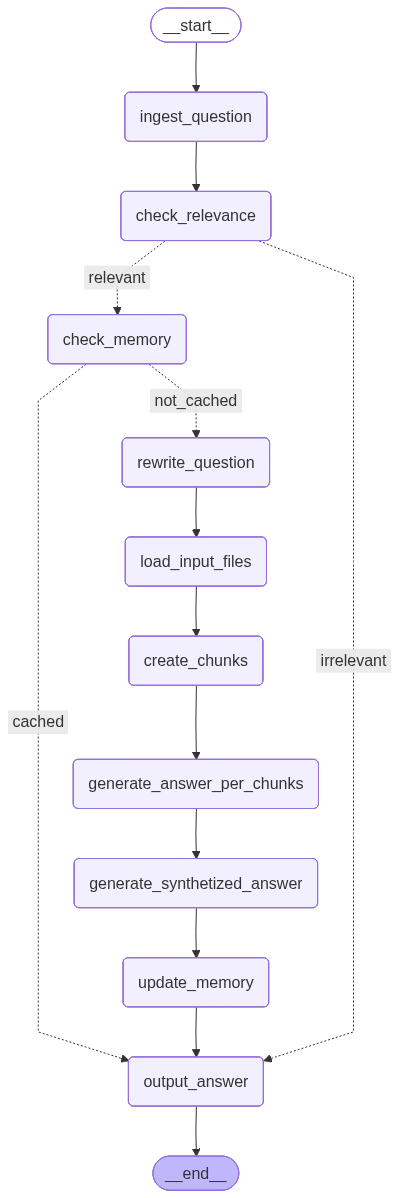

In [19]:
png = compiled_graph.get_graph().draw_mermaid_png()
display_image(png)

# Run the Agentic Workflow

In [20]:
%%time

final_graph = compiled_graph.invoke(
        input={
            "topic": TOPIC,
            "question": QUESTION,
            "input_path": INPUT_PATH, 
            "memory": memory, 
            "llm": llm,
            "messages": [],
        },
    )

🔁 Processing each chunk: 100%|██████████| 149/149 [02:54<00:00,  1.17s/it, group=✅ Chunk 149 response length: 28 chars] 


🔁 Processing each grouped chunk answers: 100%|██████████| 1/1 [00:10<00:00, 10.91s/it, group=🧠 Synthesized partial answer (1/1)]



🔚 === Final Answer ===

# 🧠 Synthesized partial answer (1/1)

# Machine Learning Classification Algorithms
## Overview
The machine learning classification algorithms mentioned or utilized in the project documentation are:

### 1. Train/Test Split
This is a technique used to evaluate the performance of a machine learning model. It involves splitting the dataset into two parts: a training set and a test set.

### 2. StandardScaler
This is a feature scaling algorithm used to scale the features of a dataset to have a mean of 0 and a standard deviation of 1. This is useful for many machine learning algorithms that assume features are on the same scale.

### 3. Logistic Regression (LR)
Logistic regression is a type of regression analysis that is used to model the relationship between a dependent variable and one or more independent variables.

### 4. Linear Discriminant Analysis (LDA)
Linear discriminant analysis (LDA) is a type of linear regression analysis that is used to model the relati

CPU times: user 2min 49s, sys: 23.9 s, total: 3min 13s
Wall time: 3min 11s


# Generated Answer

In [21]:
answer = final_graph.get('answer')
display(Markdown(answer))

# 🧠 Synthesized partial answer (1/1)

# Machine Learning Classification Algorithms
## Overview
The machine learning classification algorithms mentioned or utilized in the project documentation are:

### 1. Train/Test Split
This is a technique used to evaluate the performance of a machine learning model. It involves splitting the dataset into two parts: a training set and a test set.

### 2. StandardScaler
This is a feature scaling algorithm used to scale the features of a dataset to have a mean of 0 and a standard deviation of 1. This is useful for many machine learning algorithms that assume features are on the same scale.

### 3. Logistic Regression (LR)
Logistic regression is a type of regression analysis that is used to model the relationship between a dependent variable and one or more independent variables.

### 4. Linear Discriminant Analysis (LDA)
Linear discriminant analysis (LDA) is a type of linear regression analysis that is used to model the relationship between a dependent variable and one or more independent variables.

### 5. K-Nearest Neighbors (KNN)
K-nearest neighbors (KNN) is a type of supervised learning algorithm that is used to classify new data points based on their similarity to existing data points.

### 6. Classification and Regression Trees (CART)
Classification and regression trees (CART) is a type of decision tree algorithm that is used to classify new data points based on their similarity to existing data points.

### 7. Gaussian Naive Bayes (NB)
Gaussian naive Bayes (NB) is a type of supervised learning algorithm that is used to classify new data points based on their similarity to existing data points.

### 8. Support Vector Machines (SVM)
Support vector machines (SVM) is a type of supervised learning algorithm that is used to classify new data points based on their similarity to existing data points.

# Message History

In [22]:
pretty_json = json.dumps(final_graph.get('messages'), indent=4)
print(pretty_json)

[
    {
        "role": "developer",
        "content": "User submitted a question."
    },
    {
        "role": "user",
        "content": "Which machine learning classification algorithms are used in this project?"
    },
    {
        "role": "developer",
        "content": "\ud83e\udde0 Relevance check result:"
    },
    {
        "role": "assistant",
        "content": "yes"
    },
    {
        "role": "developer",
        "content": "\ud83e\udded No cached answer found for question: 'Which machine learning classification algorithms are used in this project?'"
    },
    {
        "role": "developer",
        "content": "\u270f\ufe0f Rewritten user question:"
    },
    {
        "role": "assistant",
        "content": "What machine learning classification algorithms are mentioned or utilized in the project documentation?"
    },
    {
        "role": "developer",
        "content": "\ud83d\udcc4 Loaded documents from: ../data/input/downloaded_repo/AI-Blueprints-main/data-scien

In [23]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed successfully.")

Built with ❤️ using [**HP AI Studio**](https://hp.com/ai-studio).